In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#실행 후 런타임 재시작

In [ ]:
!pip install pycaret[full] #런타임 재시작

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

## data load

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/train.csv')

In [ ]:
test1 = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/check0.csv')

In [ ]:
test2 = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/check1.csv')

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/submit.csv')

In [ ]:
def xy_split(df):
  y = df[['유입량']].astype(float)
  X = df.drop(['date', '홍수사상번호', '유입량', '연', '월', '일', '시간'], axis=1).astype(float)

  y = y.reset_index(drop=True)
  X = X.reset_index(drop=True)

  return y, X

y_train, X_train = xy_split(train)  #1 ~ 23번 홍수사상
y_val, X_val = xy_split(test1)   #24번 홍수사상
y_test, X_test = xy_split(test2) #25번 홍수사상

## feature selection

### lasso

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
reg = Lasso(random_state = 42).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.43695425392343, tolerance: 0.3867530251731706
  positive)


In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
coef = pd.DataFrame(reg.coef_, index=X_train.columns)

In [ ]:
coef[coef.values != 0].index

Index(['수위E_max', 'event_idx', 'lag_1_강우D_max', 'cumsum_평균강수_mean',
       'cumsum_강우A_mean', 'cumsum_강우A_max', 'cumsum_강우B_max', 'cumsum_강우D_max',
       'cumsum_수위E_max', 'cumsum_lag_1_평균강수_max', 'cumsum_lag_1_강우C_max'],
      dtype='object')

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse

mdl = XGBRegressor(random_state=42)
mdl.fit(X_train[coef[coef.values != 0].index], y_train)
y_pred_lasso_24 = mdl.predict(X_val[coef[coef.values != 0].index])
print(np.sqrt(mse(np.expm1(y_pred_lasso_24), np.expm1(y_val))))

825.7095381310312


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

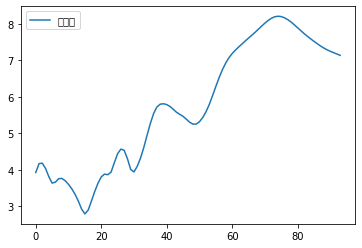

In [ ]:
y_val.plot()

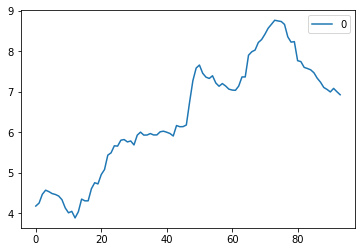

In [ ]:
pd.DataFrame(y_pred_lasso_24).plot()

In [ ]:
y_pred_lasso_25 = mdl.predict(X_test[coef[coef.values != 0].index])
np.sqrt(mse(np.expm1(y_pred_lasso_25), np.expm1(y_test)))

344.5031322715257

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

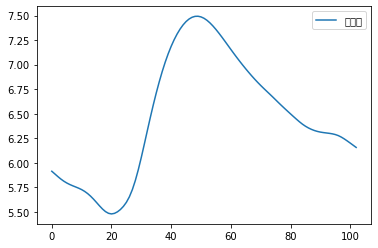

In [ ]:
y_test.plot()

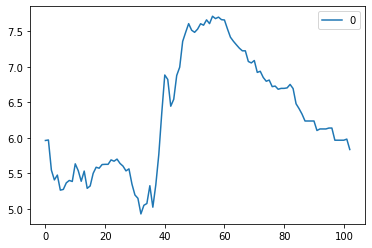

In [ ]:
pd.DataFrame(y_pred_lasso_25).plot()

### dt 기반 feature selection

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
fi = pd.DataFrame(dt.feature_importances_, index =X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

In [ ]:
fi.plot(kind='barh', title='Plots Comparison for Feature Importance', figsize=(20,40));


In [ ]:
fi[:11].index

Index(['수위E_max', '강우D_max', 'ewma_lag_1_평균강수_max', '평균강수_max', 'ma_수위E_max',
       'ewma_수위E_max', 'cumsum_강우C_max', '강우C_max', 'diff_강우D_max',
       'diff_lag_1_평균강수_max', '강우B_max'],
      dtype='object')

In [ ]:
from xgboost import XGBRegressor

mdl = XGBRegressor(random_state=42)
mdl.fit(X_train.loc[:,fi[:11].index], y_train)
y_pred_dt_24 = mdl.predict(X_val.loc[:,fi[:11].index])
np.sqrt(mse(np.expm1(y_pred_dt_24), np.expm1(y_val)))

[05:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


625.440354172971

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

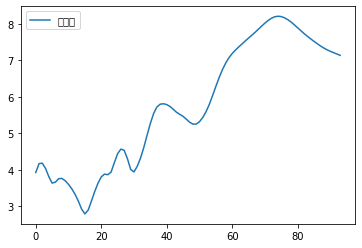

In [ ]:
y_val.plot()

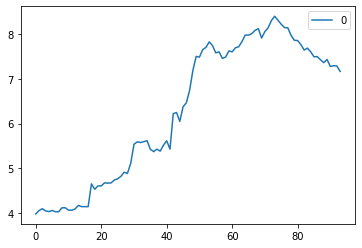

In [ ]:
pd.DataFrame(y_pred_dt_24).plot()

In [ ]:
y_pred_dt_25 = mdl.predict(X_test.loc[:,fi[:11].index])
np.sqrt(mse(np.expm1(y_pred_dt_25), np.expm1(y_test)))

211.13871405359137

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

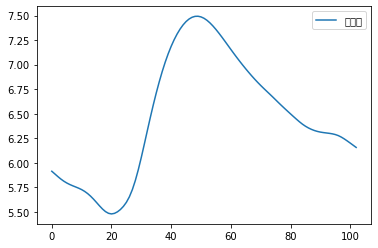

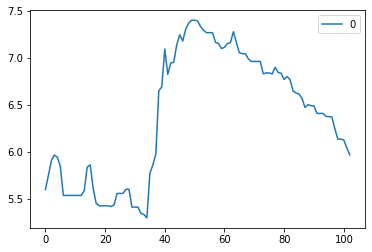

In [ ]:
y_test.plot()
pd.DataFrame(y_pred_dt_25).plot()

트리기반 앙상블 모델의 feature importance는 왜곡될 가능성이 크다. 따라서 단일 dt 모델의 feature importance를 이용해 변수선택을 진행하였다.

dt기반 선택은 25번 사상에 대해 더 좋은 예측력을 보였으나, 24번 사상에 대해서 rmse가 크게 튀는 모습으로 보아, dt기반으로 선택된 변수들은 일반화에 문제가 있는 것으로 보인다. 따라서 lasso기반 변수 선택을 이용하였다.

In [ ]:
f_select = coef[coef.values != 0].index

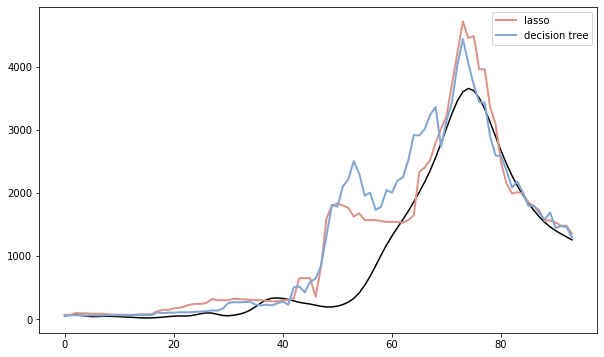

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(np.expm1(y_val), color='black')
plt.plot(np.expm1(y_pred_lasso_24), label='lasso', color='#DC948A', linewidth=2)
plt.plot(np.expm1(y_pred_dt_24), label='decision tree', color='#81A6D3', linewidth=2)
plt.legend()
plt.show()

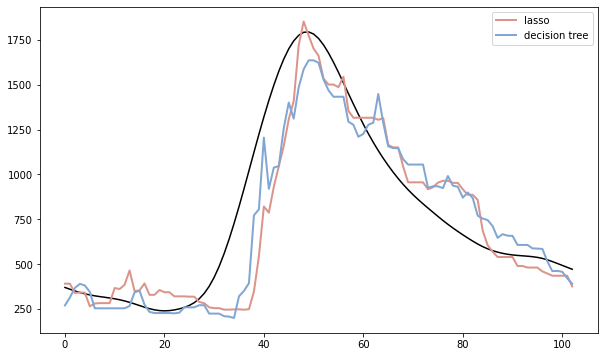

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.expm1(y_test), color='black')
plt.plot(np.expm1(y_pred_lasso_25), label='lasso', color='#DC948A', linewidth=2)
plt.plot(np.expm1(y_pred_dt_25), label='decision tree', color='#81A6D3', linewidth=2)
plt.legend()
plt.show()

# window 탐색

## window_size = 4

In [ ]:
from pycaret.regression import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
data = pd.concat([X_train.loc[:,f_select], y_train], axis=1)

In [ ]:
data[['유입량']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   유입량     2694 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB


In [ ]:
clf = pycaret.regression.setup(data = data, target = '유입량', use_gpu = True, session_id=42)

,Description,Value
0,session_id,42
1,Target,유입량
2,Original Data,"(2694, 12)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1885, 9)"


In [ ]:
best_10 = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0744,0.0262,0.1557,0.9818,0.0229,0.0117,1.391
catboost,CatBoost Regressor,0.1016,0.0308,0.1713,0.9785,0.0255,0.0162,2.787
xgboost,Extreme Gradient Boosting,0.1036,0.0370,0.1867,0.9742,0.0278,0.0166,1.052
rf,Random Forest Regressor,0.1025,0.0385,0.1930,0.9730,0.0280,0.0162,1.582
lightgbm,Light Gradient Boosting Machine,0.1158,0.0396,0.1957,0.9721,0.0291,0.0186,0.137
gbr,Gradient Boosting Regressor,0.1649,0.0613,0.2451,0.9568,0.0355,0.0262,0.401
dt,Decision Tree Regressor,0.1296,0.0741,0.2686,0.9481,0.0388,0.0205,0.022
ada,AdaBoost Regressor,0.2703,0.1221,0.3480,0.9134,0.0484,0.0425,0.203
knn,K Neighbors Regressor,0.2372,0.1854,0.4249,0.8701,0.0581,0.0373,0.191
ridge,Ridge Regression,0.3044,0.1911,0.4347,0.8649,0.0648,0.0499,0.014


In [ ]:
cat = create_model('catboost', cross_validation = False)
xgb = create_model('xgboost', cross_validation = False)
rf = create_model('rf', cross_validation = False)
et = create_model('et', cross_validation = False)
lgbm = create_model('lightgbm', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1746,0.0651,0.2551,0.9562,0.0383,0.0283


In [ ]:
tuned_cat = tune_model(cat, optimize = 'RMSE', n_iter = 10, search_library='optuna')
tuned_xgb = tune_model(xgb, optimize = 'RMSE', n_iter = 10,search_library='optuna')
tuned_rf = tune_model(rf, optimize = 'RMSE', n_iter = 10,search_library='optuna')
tuned_et = tune_model(et, optimize = 'RMSE', n_iter = 10,search_library='optuna')
tuned_lgbm = tune_model(lgbm, optimize = 'RMSE', n_iter = 10,search_library='optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2002,0.0813,0.2851,0.9402,0.0374,0.0296
1,0.1889,0.0636,0.2521,0.9474,0.0342,0.0290
2,0.2300,0.1339,0.3660,0.9039,0.0679,0.0433
3,0.2227,0.1022,0.3197,0.9271,0.0422,0.0334
4,0.2469,0.1705,0.4130,0.8929,0.0740,0.0456
5,0.1889,0.0642,0.2533,0.9553,0.0352,0.0291
6,0.2047,0.0850,0.2915,0.9459,0.0452,0.0338
7,0.2347,0.1252,0.3538,0.9135,0.0526,0.0372
8,0.2235,0.0922,0.3037,0.9346,0.0410,0.0340
9,0.2105,0.0893,0.2988,0.9291,0.0408,0.0321


In [ ]:
blender_specific_t = blend_models(estimator_list = [tuned_cat,tuned_xgb,tuned_rf,tuned_et,tuned_lgbm], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6632,0.5026,0.7090,0.6304,0.0891,0.0928
1,0.6034,0.4144,0.6437,0.6568,0.0825,0.0862
2,0.6184,0.4356,0.6600,0.6875,0.0894,0.0923
3,0.6531,0.4915,0.7010,0.6495,0.0882,0.0916
4,0.6675,0.5310,0.7287,0.6666,0.0994,0.0996
5,0.6228,0.4391,0.6627,0.6939,0.0840,0.0884
6,0.6134,0.4397,0.6631,0.7200,0.0855,0.0889
7,0.6768,0.5261,0.7253,0.6364,0.0922,0.0956
8,0.6345,0.4628,0.6803,0.6716,0.0857,0.0894
9,0.6326,0.4587,0.6773,0.6356,0.0868,0.0901


In [ ]:
final_model_t = finalize_model(blender_specific_t)

[LightGBM] [Warning] feature_fraction is set=0.8408695045082575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408695045082575
[LightGBM] [Warning] bagging_fraction is set=0.516393690307754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.516393690307754
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8408695045082575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408695045082575
[LightGBM] [Warning] bagging_fraction is set=0.516393690307754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.516393690307754
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8408695045082575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408695045082575
[LightGBM] [Warning] bagging_fra

In [ ]:
pred = predict_model(final_model_t, data = X_val)

In [ ]:
pred2 = predict_model(final_model_t, data = X_test)

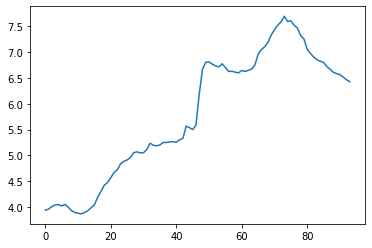

In [ ]:
pred.Label.plot()

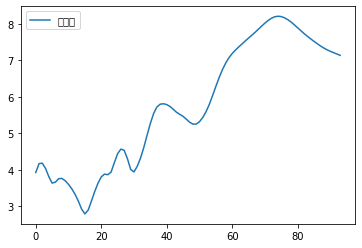

In [ ]:
y_val.plot()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(np.expm1(y_val),np.expm1(pred.Label)))

728.9092750721007

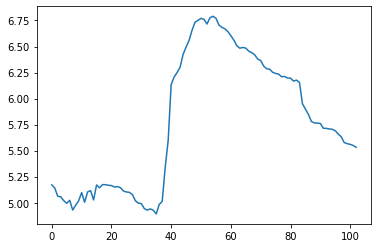

In [ ]:
pred2.Label.plot()

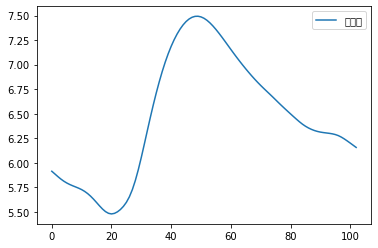

In [ ]:
y_test.plot()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(np.expm1(y_test),np.expm1(pred2.Label)))

484.6072622762702

## window size=5

In [ ]:
train_5 = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/train_std_5.csv')

In [ ]:
test1_5 = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/check0_std_5.csv')

In [ ]:
test2_5 = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/check1_std_5.csv')

In [ ]:
submit_5 = pd.read_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/tmp/submit_std_5.csv')

In [ ]:
def xy_split(df):
  y = df[['유입량']].astype(float)
  X = df.drop(['date', '홍수사상번호', '유입량', '연', '월', '일', '시간'], axis=1).astype(float)

  y = y.reset_index(drop=True)
  X = X.reset_index(drop=True)

  return y, X

y_train_5, X_train_5 = xy_split(train_5)  #1 ~ 23번 홍수사상
y_val_5, X_val_5 = xy_split(test1_5)   #24번 홍수사상
y_test_5, X_test_5 = xy_split(test2_5) #25번 홍수사상

In [ ]:
data5 = pd.concat([X_train_5.loc[:,f_select], y_train_5], axis=1)

In [ ]:
data5[['유입량']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   유입량     2694 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB


In [ ]:
clf_2 = pycaret.regression.setup(data = data5, target = '유입량', use_gpu = True, session_id=42)

,Description,Value
0,session_id,42
1,Target,유입량
2,Original Data,"(2694, 12)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1885, 9)"


In [ ]:
best_10_5 = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0744,0.0262,0.1557,0.9818,0.0229,0.0117,1.387
catboost,CatBoost Regressor,0.1016,0.0308,0.1713,0.9785,0.0255,0.0162,2.791
xgboost,Extreme Gradient Boosting,0.1036,0.0370,0.1867,0.9742,0.0278,0.0166,1.014
rf,Random Forest Regressor,0.1025,0.0385,0.1930,0.9730,0.0280,0.0162,1.590
lightgbm,Light Gradient Boosting Machine,0.1158,0.0396,0.1957,0.9721,0.0291,0.0186,0.134
gbr,Gradient Boosting Regressor,0.1649,0.0613,0.2451,0.9568,0.0355,0.0262,0.406
dt,Decision Tree Regressor,0.1296,0.0741,0.2686,0.9481,0.0388,0.0205,0.021
ada,AdaBoost Regressor,0.2703,0.1221,0.3480,0.9134,0.0484,0.0425,0.205
knn,K Neighbors Regressor,0.2372,0.1854,0.4249,0.8701,0.0581,0.0373,0.021
ridge,Ridge Regression,0.3044,0.1911,0.4347,0.8649,0.0648,0.0499,0.016


In [ ]:
cat5 = create_model('catboost', cross_validation = False)
xgb5 = create_model('xgboost', cross_validation = False)
rf5 = create_model('rf', cross_validation = False)
et5 = create_model('et', cross_validation = False)
lgbm5 = create_model('lightgbm', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1167,0.0369,0.1921,0.9752,0.0301,0.019


In [ ]:
tuned_cat5 = tune_model(cat5, optimize = 'RMSE', n_iter = 10, search_library='optuna')
tuned_xgb5 = tune_model(xgb5, optimize = 'RMSE', n_iter = 10,search_library='optuna')
tuned_rf5 = tune_model(rf5, optimize = 'RMSE', n_iter = 10,search_library='optuna')
tuned_et5 = tune_model(et5, optimize = 'RMSE', n_iter = 10,search_library='optuna')
tuned_lgbm5 = tune_model(lgbm5, optimize = 'RMSE', n_iter = 10,search_library='optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1713,0.0605,0.2459,0.9555,0.0323,0.0252
1,0.1463,0.0426,0.2065,0.9647,0.0283,0.0226
2,0.1577,0.0727,0.2696,0.9479,0.0534,0.0302
3,0.1719,0.0663,0.2574,0.9527,0.0356,0.0264
4,0.1994,0.1229,0.3506,0.9228,0.0633,0.0367
5,0.1430,0.0417,0.2041,0.9710,0.0287,0.0224
6,0.1542,0.0607,0.2464,0.9613,0.0367,0.0251
7,0.1706,0.0722,0.2687,0.9501,0.0374,0.0263
8,0.1548,0.0496,0.2228,0.9648,0.0301,0.0238
9,0.1580,0.0653,0.2555,0.9482,0.0351,0.0241


In [ ]:
blender_specific_t5 = blend_models(estimator_list = [tuned_cat5,tuned_xgb5,tuned_rf5,tuned_et5,tuned_lgbm5], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6690,0.5217,0.7223,0.6163,0.0905,0.0934
1,0.6034,0.4243,0.6514,0.6486,0.0834,0.0860
2,0.6206,0.4475,0.6690,0.6789,0.0921,0.0933
3,0.6508,0.5024,0.7088,0.6416,0.0892,0.0911
4,0.6751,0.5589,0.7476,0.6490,0.1025,0.1008
5,0.6242,0.4532,0.6732,0.6841,0.0853,0.0883
6,0.6223,0.4606,0.6787,0.7067,0.0878,0.0905
7,0.6852,0.5552,0.7451,0.6163,0.0948,0.0965
8,0.6332,0.4708,0.6861,0.6659,0.0861,0.0889
9,0.6322,0.4759,0.6898,0.6220,0.0882,0.0896


In [ ]:
final_model_t5 = finalize_model(blender_specific_t5)

[LightGBM] [Warning] feature_fraction is set=0.4769473169413719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769473169413719
[LightGBM] [Warning] bagging_fraction is set=0.7376939250590897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7376939250590897
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4769473169413719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769473169413719
[LightGBM] [Warning] bagging_fraction is set=0.7376939250590897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7376939250590897
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4769473169413719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769473169413719
[LightGBM] [Warning] bagging

In [ ]:
pred = predict_model(final_model_t5, data = X_val_5)

In [ ]:
pred2 = predict_model(final_model_t5, data = X_test_5)

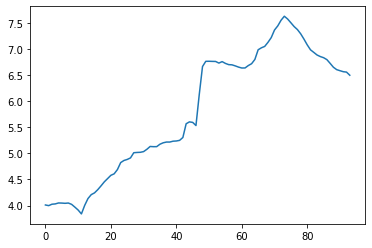

In [ ]:
pred.Label.plot()

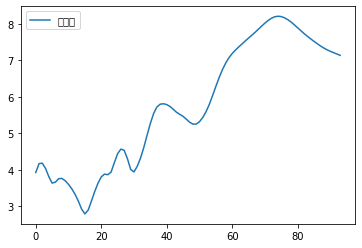

In [ ]:
y_val.plot()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(np.expm1(y_val_5),np.expm1(pred.Label)))

752.2217180456671

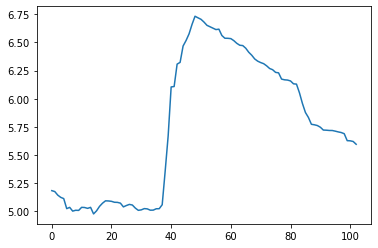

In [ ]:
pred2.Label.plot()

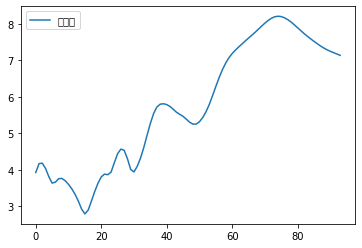

In [ ]:
y_val_5.plot()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(np.expm1(y_test_5),np.expm1(pred2.Label)))

498.8954453836323

window size 4가 더 좋다.

# 최종 튜닝

In [ ]:
data1 = pd.concat([X_train.loc[:,f_select], y_train], axis=1)
data2 = pd.concat([X_val.loc[:,f_select], y_val], axis=1)
data3 = pd.concat([X_test.loc[:,f_select], y_test], axis=1)
data_final = pd.concat([data1, data2, data3], axis=0)

In [ ]:
clf = pycaret.regression.setup(data = data_final, target = '유입량', use_gpu = True)

,Description,Value
0,session_id,2194
1,Target,유입량
2,Original Data,"(2891, 12)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2023, 9)"


In [ ]:
cat = create_model('catboost', cross_validation = False)
xgb = create_model('xgboost', cross_validation = False)
rf = create_model('rf', cross_validation = False)
et = create_model('et', cross_validation = False)
lgbm = create_model('lightgbm', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1279,0.0522,0.2284,0.9675,0.039,0.0226


In [ ]:
tuned_cat = tune_model(cat, optimize = 'RMSE', n_iter = 10, search_library='optuna',choose_better=True)
tuned_xgb = tune_model(xgb, optimize = 'RMSE', n_iter = 10,search_library='optuna',choose_better=True)
tuned_rf = tune_model(rf, optimize = 'RMSE', n_iter = 10,search_library='optuna',choose_better=True)
tuned_et = tune_model(et, optimize = 'RMSE', n_iter = 10,search_library='optuna',choose_better=True)
tuned_lgbm = tune_model(lgbm, optimize = 'RMSE', n_iter = 10,search_library='optuna',choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1563,0.0617,0.2483,0.9550,0.0338,0.0243
1,0.1505,0.0542,0.2329,0.9625,0.0331,0.0239
2,0.1653,0.0627,0.2504,0.9575,0.0384,0.0272
3,0.1967,0.1216,0.3487,0.9127,0.0594,0.0357
4,0.1875,0.0758,0.2753,0.9507,0.0375,0.0286
5,0.1704,0.0725,0.2692,0.9405,0.0357,0.0255
6,0.1659,0.0565,0.2376,0.9608,0.0343,0.0270
7,0.1651,0.0688,0.2623,0.9498,0.0392,0.0263
8,0.1784,0.0712,0.2668,0.9569,0.0430,0.0309
9,0.1549,0.0552,0.2349,0.9624,0.0332,0.0248


In [ ]:
tuned_cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 2194,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.044245000928640366,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iteration

In [ ]:
tuned_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=2194, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=0)

In [ ]:
tuned_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=2194, verbose=0, warm_start=False)

In [ ]:
tuned_et

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=2194, verbose=0, warm_start=False)

In [ ]:
tuned_lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=2194, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
blender_specific_t = blend_models(estimator_list = [tuned_cat,tuned_xgb,tuned_rf,tuned_et,tuned_lgbm], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0867,0.0283,0.1684,0.9793,0.0220,0.0133
1,0.0710,0.0153,0.1236,0.9894,0.0166,0.0109
2,0.0881,0.0188,0.1372,0.9873,0.0208,0.0143
3,0.1178,0.0648,0.2545,0.9535,0.0411,0.0206
4,0.0949,0.0280,0.1674,0.9818,0.0214,0.0139
5,0.0927,0.0293,0.1712,0.9759,0.0221,0.0136
6,0.1048,0.0298,0.1726,0.9793,0.0250,0.0170
7,0.0838,0.0225,0.1500,0.9836,0.0219,0.0132
8,0.0929,0.0303,0.1741,0.9816,0.0322,0.0165
9,0.0727,0.0164,0.1282,0.9888,0.0182,0.0115


In [ ]:
final_model_t = finalize_model(blender_specific_t)

In [ ]:
save_model(final_model_t,'/content/drive/MyDrive/빅콘2021/final_model_t2.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='유입량',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                                                             colsample_bytree=1.0,
                                                             importance_type='split',
                                                             learning_rate=0.1,
                                                             max

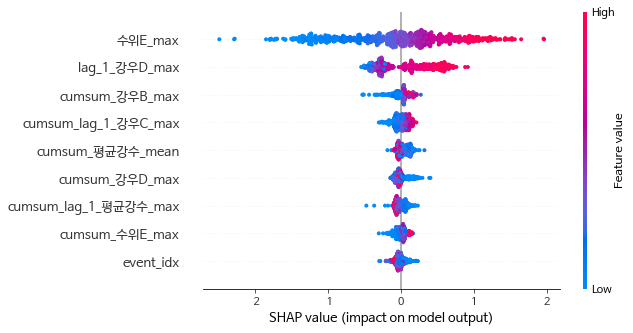

In [ ]:
interpret_model(tuned_xgb)

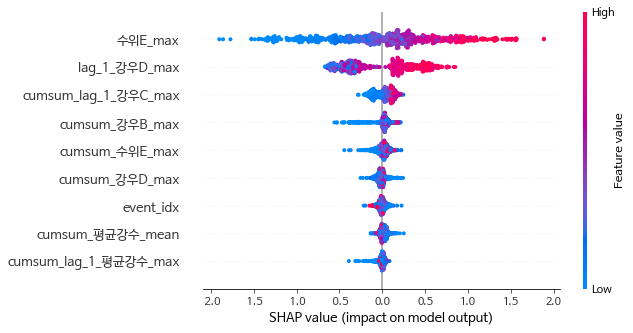

In [ ]:
interpret_model(tuned_cat)

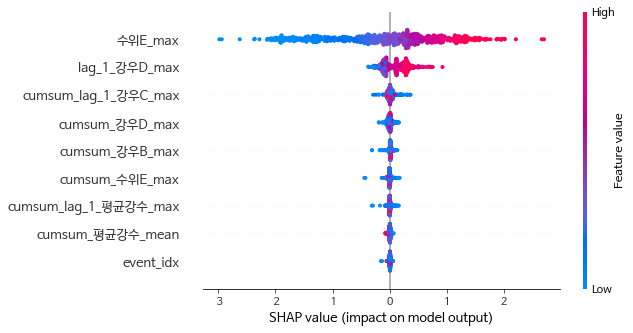

In [ ]:
interpret_model(tuned_rf)

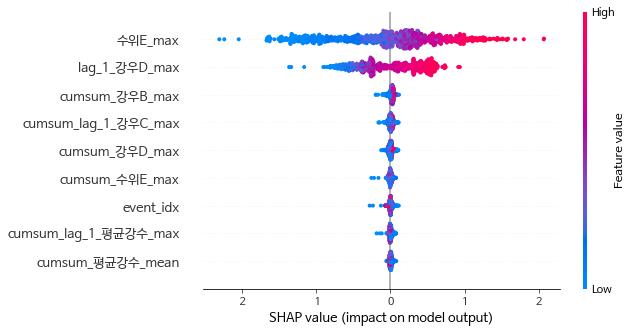

In [ ]:
interpret_model(tuned_et)

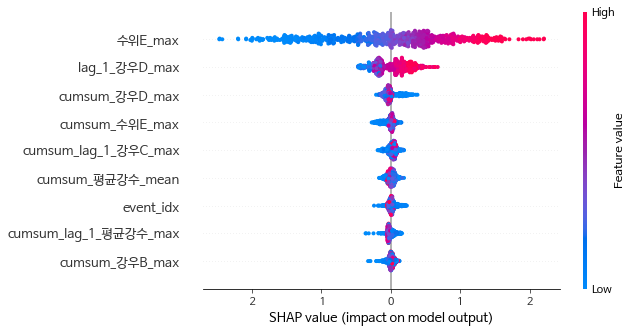

In [ ]:
interpret_model(tuned_lgbm)

# 예측결과 확인

## blending

In [ ]:
pred = predict_model(final_model_t, data = X_val)

In [ ]:
pred2 = predict_model(final_model_t, data = X_test)

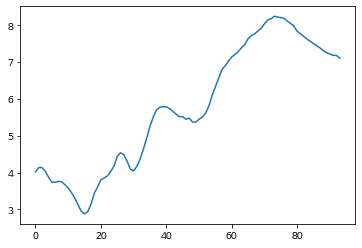

In [ ]:
pred.Label.plot()

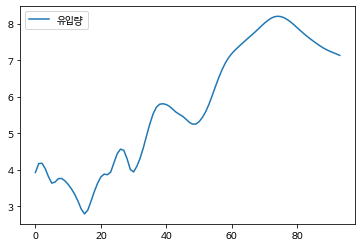

In [ ]:
y_val.plot()

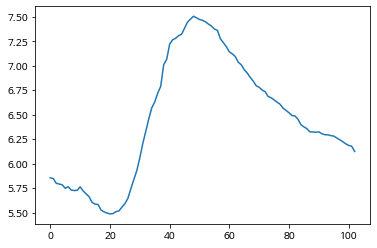

In [ ]:
pred2.Label.plot()

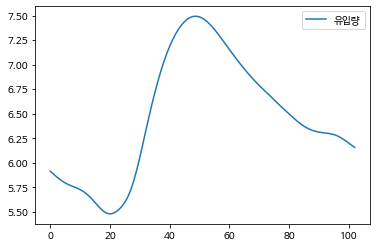

In [ ]:
y_test.plot()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(np.expm1(pred.Label), np.expm1(y_val)))

49.17078228031593

In [ ]:
np.sqrt(mse(np.expm1(pred2.Label), np.expm1(y_test)))

29.153523885864185

In [ ]:
pred.Label.to_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/result_val_ml.csv')

In [ ]:
pred2.Label.to_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/result_test_ml.csv')

In [ ]:
predict_model(final_model_t, data = X_train).to_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/result_train_ml.csv')

In [ ]:
predict_model(final_model_t, data = submit.loc[:,f_select]).to_csv('/content/drive/MyDrive/빅콘2021/제출용 파일/result_submit_ml.csv')

In [ ]:
predict_model(final_model_t, data = submit.loc[:,f_select]).Label.plot()